In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import anndata as ad
import scvelo as scv
import scipy as sp
from scipy import special
from scipy.stats import poisson,norm
from scipy.special import j_roots
from scipy.special import beta as beta_fun 
from matplotlib.pyplot import rc_context
import seaborn as sns

In [2]:
scv.set_figure_params(dpi=100, color_map = 'viridis_r')
scv.settings.verbosity = 1
sc.logging.print_header()

scanpy==1.7.2 anndata==0.8.0 umap==0.4.1 numpy==1.19.5 scipy==1.8.0 pandas==1.4.1 scikit-learn==1.0.2 statsmodels==0.13.2 python-igraph==0.9.9


In [3]:
# read UMI counts and params for c57 and cast viariants
UMI_c57 = pd.read_csv('data_arme/F1_ref/umiSplit_c57.qc.csv', index_col=0)
params_c57 = pd.read_csv('data_arme/F1_ref/umiSplit_c57.qc.maxl.ci.wfilt1.csv', index_col=0, header=None)
UMI_cast = pd.read_csv('data_arme/F1_ref/umiSplit_cast.qc.csv', index_col=0)
params_cast = pd.read_csv('data_arme/F1_ref/umiSplit_cast.qc.maxl.ci.wfilt1.csv', index_col=0, header=None)

In [4]:
# sum the UMI counts into a single dataframe
UMI = UMI_c57 + UMI_cast

In [5]:
UMI.head(5)

,GCTTAGAGAAGACC,GCTTAGGTAAGTGG,GCTTAGTCCGTGTT,GTTGGAGTCTATTA,GTTGGAGAAGGCGT,GGATTCAGGTAGTG,ATGCCGGATGTCCT,ACGGTCGTTGTCTG,ACGAGTGCGATGAT,GCTTAGTACGACAC,...,GCGGTTTTGACCTA,CACTGTGACGTCCA,GCGGTTGTCAAGAC,GGATCACGGTGCTT,GCGGTTGTACAACG,GCGGTTAATCACGA,GCGGTTCTTCATCC,GCGGTTCATGAGTA,GCGGTTAACCAGAG,GCGGTTCACCGTCT
ENSMUSG00000000001,21.0,16.0,35.0,30.0,35.0,46.0,63.0,23.0,38.0,9.0,...,26.0,14.0,15.0,22.0,26.0,25.0,20.0,14.0,16.0,24.0
ENSMUSG00000000028,0.0,0.0,0.0,5.0,2.0,0.0,3.0,1.0,0.0,NaN,...,2.0,NaN,0.0,NaN,0.0,4.0,15.0,0.0,0.0,15.0
ENSMUSG00000000037,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000049,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSMUSG00000000056,1.0,3.0,4.0,NaN,1.0,2.0,0.0,0.0,0.0,2.0,...,2.0,0.0,1.0,1.0,NaN,0.0,0.0,2.0,2.0,1.0


In [6]:
# transpose to ge n_cells x n_genes shape
UMI_c57_T = UMI_c57.transpose(copy=True)
UMI_cast_T = UMI_cast.transpose(copy=True)
UMI_T = UMI.transpose(copy=True)

In [7]:
UMI_c57_T = UMI_c57_T.dropna(axis=1)
UMI_cast_T = UMI_cast_T.dropna(axis=1)
UMI_T = UMI_T.dropna(axis=1)

In [8]:
common_cols1 = UMI_c57_T.columns.intersection(UMI_cast_T.columns)
common_cols2 = UMI_cast_T.columns.intersection(UMI_T.columns)
common_cols = common_cols1.intersection(common_cols2)
common_cols

Index(['ENSMUSG00000000001', 'ENSMUSG00000000049', 'ENSMUSG00000000088',
       'ENSMUSG00000000120', 'ENSMUSG00000000184', 'ENSMUSG00000000214',
       'ENSMUSG00000000295', 'ENSMUSG00000000303', 'ENSMUSG00000000326',
       'ENSMUSG00000000339',
       ...
       'ENSMUSG00000114686', 'ENSMUSG00000114828', 'ENSMUSG00000114922',
       'ENSMUSG00000114945', 'ENSMUSG00000115141', 'ENSMUSG00000115367',
       'ENSMUSG00000115454', 'ENSMUSG00000115526', 'ENSMUSG00000115643',
       'ENSMUSG00000115811'],
      dtype='object', length=5066)

In [9]:
UMI_c57_T = UMI_c57_T[common_cols]
UMI_cast_T = UMI_cast_T[common_cols]
UMI_T = UMI_T[common_cols]

In [10]:
UMI_c57_T = UMI_c57_T.reindex()
UMI_cast_T = UMI_cast_T.reindex()
UMI_T = UMI_T.reindex()

In [11]:
UMI_T.head()

,ENSMUSG00000000001,ENSMUSG00000000049,ENSMUSG00000000088,ENSMUSG00000000120,ENSMUSG00000000184,ENSMUSG00000000214,ENSMUSG00000000295,ENSMUSG00000000303,ENSMUSG00000000326,ENSMUSG00000000339,...,ENSMUSG00000114686,ENSMUSG00000114828,ENSMUSG00000114922,ENSMUSG00000114945,ENSMUSG00000115141,ENSMUSG00000115367,ENSMUSG00000115454,ENSMUSG00000115526,ENSMUSG00000115643,ENSMUSG00000115811
GCTTAGAGAAGACC,21.0,0.0,34.0,0.0,123.0,0.0,3.0,0.0,15.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCTTAGGTAAGTGG,16.0,2.0,14.0,0.0,18.0,0.0,2.0,0.0,31.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GCTTAGTCCGTGTT,35.0,0.0,23.0,0.0,164.0,0.0,9.0,0.0,36.0,9.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTTGGAGTCTATTA,30.0,0.0,18.0,0.0,157.0,0.0,15.0,0.0,62.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
GTTGGAGAAGGCGT,35.0,0.0,30.0,0.0,171.0,0.0,11.0,0.0,48.0,13.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
allele_1 = UMI_c57_T / (UMI_c57_T + UMI_cast_T)
allele_1

,ENSMUSG00000000001,ENSMUSG00000000049,ENSMUSG00000000088,ENSMUSG00000000120,ENSMUSG00000000184,ENSMUSG00000000214,ENSMUSG00000000295,ENSMUSG00000000303,ENSMUSG00000000326,ENSMUSG00000000339,...,ENSMUSG00000114686,ENSMUSG00000114828,ENSMUSG00000114922,ENSMUSG00000114945,ENSMUSG00000115141,ENSMUSG00000115367,ENSMUSG00000115454,ENSMUSG00000115526,ENSMUSG00000115643,ENSMUSG00000115811
GCTTAGAGAAGACC,0.714286,NaN,0.588235,NaN,0.357724,NaN,1.000000,NaN,0.666667,0.800000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCTTAGGTAAGTGG,0.250000,1.0,0.785714,NaN,0.944444,NaN,0.000000,NaN,0.806452,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCTTAGTCCGTGTT,0.314286,NaN,0.652174,NaN,0.378049,NaN,0.111111,NaN,0.694444,0.444444,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTTGGAGTCTATTA,0.433333,NaN,0.666667,NaN,0.541401,NaN,0.600000,NaN,0.693548,0.750000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTTGGAGAAGGCGT,0.571429,NaN,0.400000,NaN,0.684211,NaN,0.909091,NaN,0.708333,0.615385,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCGGTTAATCACGA,0.480000,NaN,0.500000,NaN,0.550000,NaN,0.705882,NaN,0.600000,0.714286,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCGGTTCTTCATCC,0.450000,NaN,0.500000,NaN,0.537500,NaN,0.222222,NaN,0.263158,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCGGTTCATGAGTA,0.571429,NaN,0.285714,NaN,0.533898,NaN,0.400000,NaN,0.606061,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCGGTTAACCAGAG,0.562500,NaN,0.000000,NaN,0.333333,NaN,0.750000,NaN,0.285714,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
allele_2 = UMI_cast_T / (UMI_c57_T + UMI_cast_T)
allele_2

,ENSMUSG00000000001,ENSMUSG00000000049,ENSMUSG00000000088,ENSMUSG00000000120,ENSMUSG00000000184,ENSMUSG00000000214,ENSMUSG00000000295,ENSMUSG00000000303,ENSMUSG00000000326,ENSMUSG00000000339,...,ENSMUSG00000114686,ENSMUSG00000114828,ENSMUSG00000114922,ENSMUSG00000114945,ENSMUSG00000115141,ENSMUSG00000115367,ENSMUSG00000115454,ENSMUSG00000115526,ENSMUSG00000115643,ENSMUSG00000115811
GCTTAGAGAAGACC,0.285714,NaN,0.411765,NaN,0.642276,NaN,0.000000,NaN,0.333333,0.200000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCTTAGGTAAGTGG,0.750000,0.0,0.214286,NaN,0.055556,NaN,1.000000,NaN,0.193548,0.333333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCTTAGTCCGTGTT,0.685714,NaN,0.347826,NaN,0.621951,NaN,0.888889,NaN,0.305556,0.555556,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTTGGAGTCTATTA,0.566667,NaN,0.333333,NaN,0.458599,NaN,0.400000,NaN,0.306452,0.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GTTGGAGAAGGCGT,0.428571,NaN,0.600000,NaN,0.315789,NaN,0.090909,NaN,0.291667,0.384615,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GCGGTTAATCACGA,0.520000,NaN,0.500000,NaN,0.450000,NaN,0.294118,NaN,0.400000,0.285714,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCGGTTCTTCATCC,0.550000,NaN,0.500000,NaN,0.462500,NaN,0.777778,NaN,0.736842,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCGGTTCATGAGTA,0.428571,NaN,0.714286,NaN,0.466102,NaN,0.600000,NaN,0.393939,0.500000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GCGGTTAACCAGAG,0.437500,NaN,1.000000,NaN,0.666667,NaN,0.250000,NaN,0.714286,0.666667,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
allele_1_std = allele_1.std(axis=0)
allele_1_std

ENSMUSG00000000001    0.157535
ENSMUSG00000000049    0.498447
ENSMUSG00000000088    0.151797
ENSMUSG00000000120    0.000000
ENSMUSG00000000184    0.144606
                        ...   
ENSMUSG00000115367         NaN
ENSMUSG00000115454         NaN
ENSMUSG00000115526         NaN
ENSMUSG00000115643         NaN
ENSMUSG00000115811         NaN
Length: 5066, dtype: float64

In [15]:
allele_2_std = allele_2.std(axis=0)
allele_2_std

ENSMUSG00000000001    0.157535
ENSMUSG00000000049    0.498447
ENSMUSG00000000088    0.151797
ENSMUSG00000000120    0.000000
ENSMUSG00000000184    0.144606
                        ...   
ENSMUSG00000115367         NaN
ENSMUSG00000115454         NaN
ENSMUSG00000115526         NaN
ENSMUSG00000115643         NaN
ENSMUSG00000115811         NaN
Length: 5066, dtype: float64

In [16]:
allele_1_std = allele_1_std.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
allele_2_std = allele_2_std.replace([np.inf, -np.inf], np.nan).dropna(axis=0)

In [17]:
np.sum(allele_1_std)

846.1942472732401

In [18]:
np.sum(allele_2_std)

846.1942472732401

<AxesSubplot:ylabel='Density'>

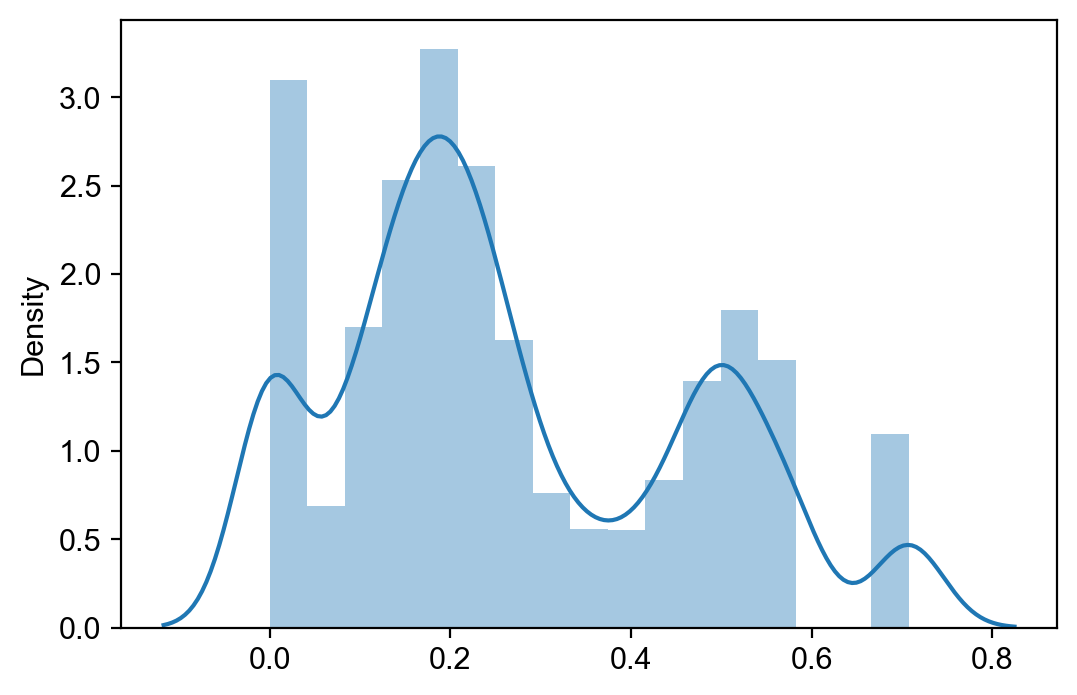

In [21]:
sns.distplot(allele_1_std)

In [28]:
df = pd.DataFrame(
    {
        "allele_1_sum": allele_1.sum(axis=0)[allele_1_std.index],
        "allele_1_mean": allele_1.mean(axis=0)[allele_1_std.index],
        "allele_2_sum": allele_2.sum(axis=0)[allele_1_std.index],
        "allele_2_mean": allele_2.mean(axis=0)[allele_1_std.index],
        "std": allele_1_std[allele_1_std.index],
    },
    index=allele_1_std.index,
)
df.head()

,allele_1_sum,allele_1_mean,allele_2_sum,allele_2_mean,std
ENSMUSG00000000001,321.291178,0.471101,360.708822,0.528899,0.157535
ENSMUSG00000000049,29.500000,0.460938,34.500000,0.539062,0.498447
ENSMUSG00000000088,350.605317,0.514084,331.394683,0.485916,0.151797
ENSMUSG00000000120,0.000000,0.000000,3.000000,1.000000,0.000000
ENSMUSG00000000184,357.947744,0.524850,324.052256,0.475150,0.144606


<AxesSubplot:xlabel='std', ylabel='allele_1_sum'>

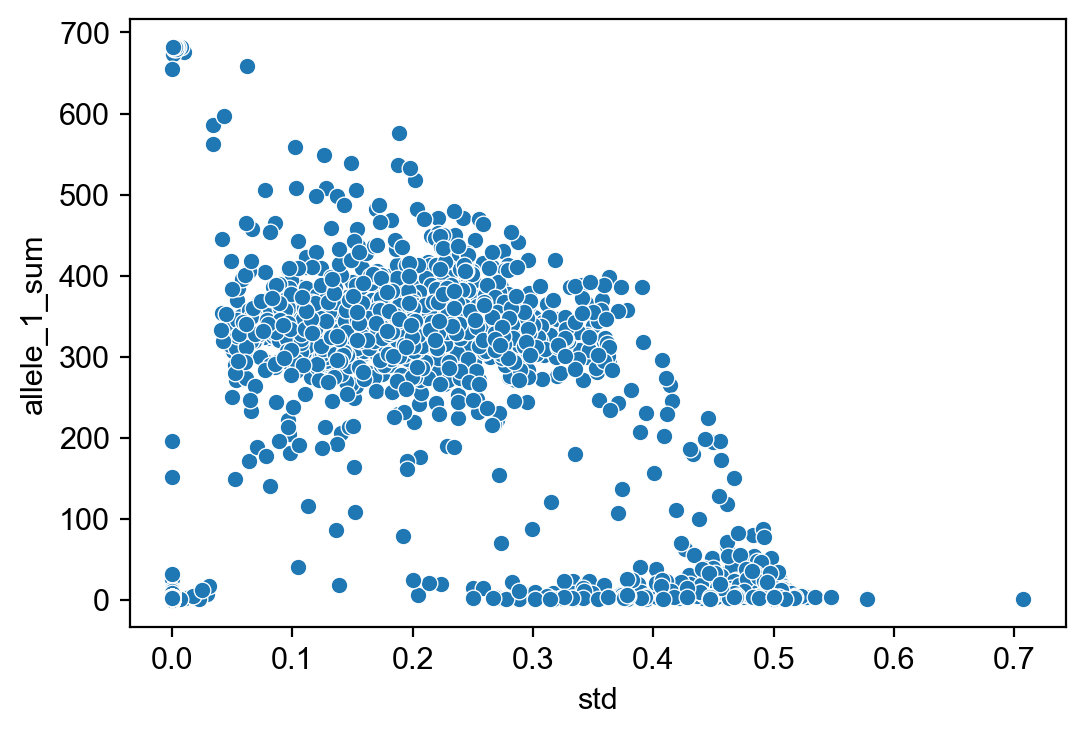

In [33]:
sns.scatterplot(data=df, x="std", y="allele_1_sum")

<AxesSubplot:xlabel='std', ylabel='allele_1_mean'>

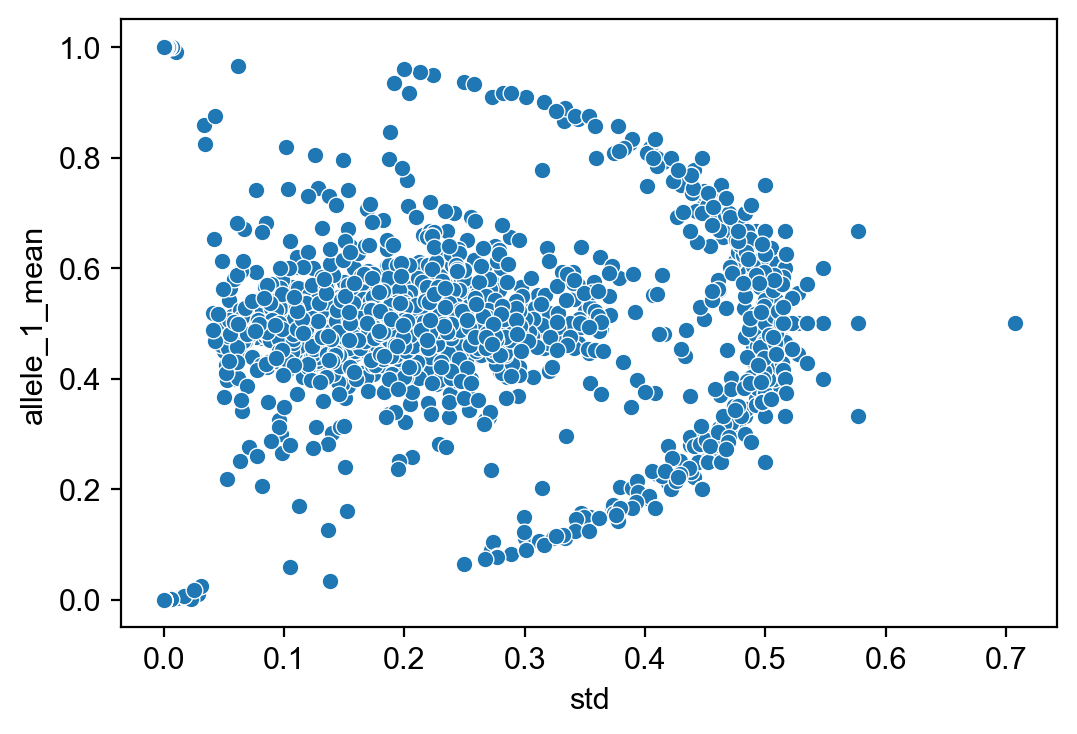

In [32]:
sns.scatterplot(data=df, x="std", y="allele_1_mean")

<AxesSubplot:xlabel='std', ylabel='allele_2_sum'>

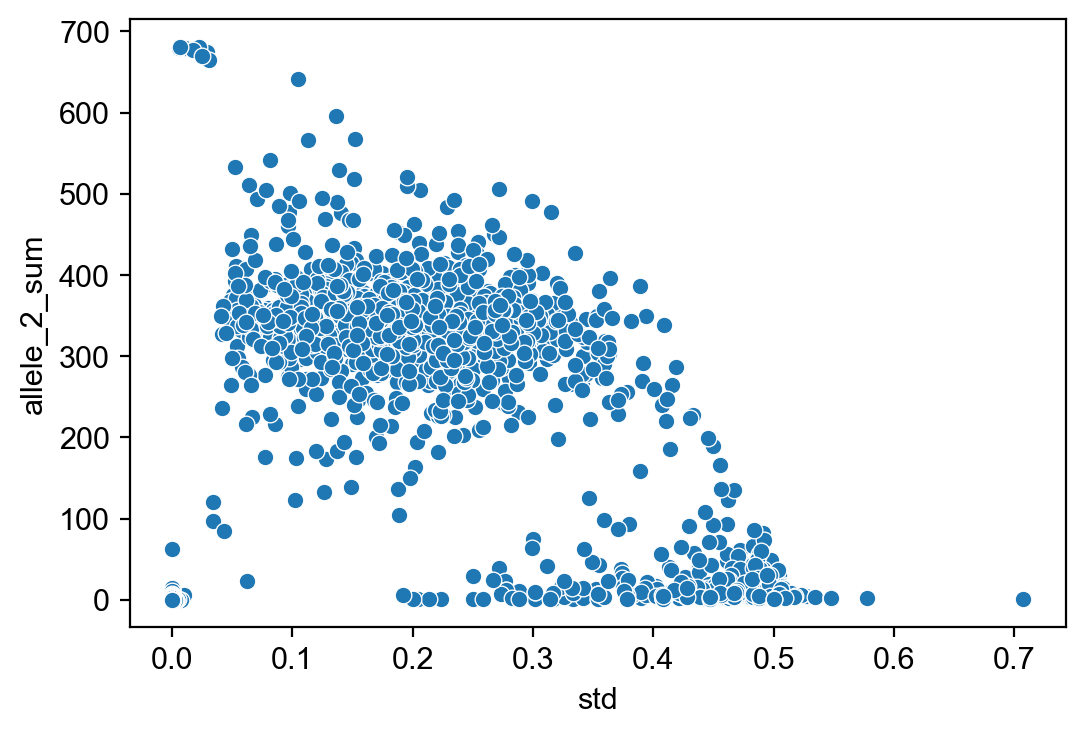

In [34]:
sns.scatterplot(data=df, x="std", y="allele_2_sum")

<AxesSubplot:xlabel='std', ylabel='allele_2_mean'>

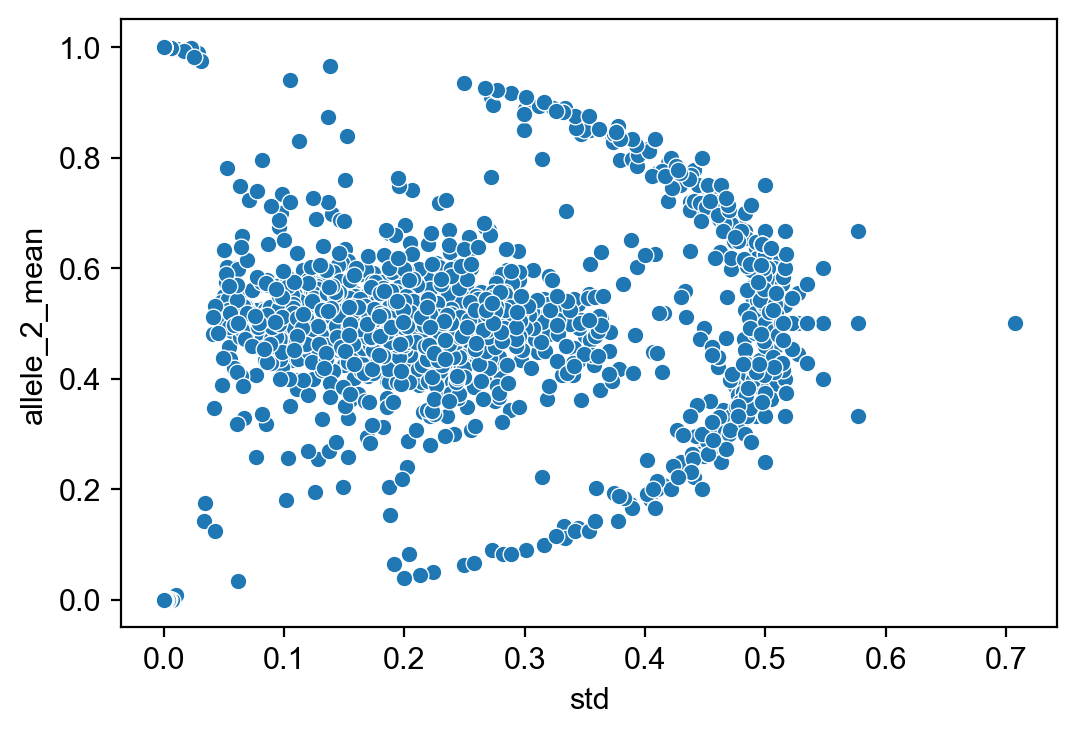

In [36]:
sns.scatterplot(data=df, x="std", y="allele_2_mean")

In [38]:
df.to_csv("data/std_data.csv", sep=";")